# Train JSONL EDA (Gemma 2B / MLX Tokenizer)

Bu notebook `data/train.jsonl` dosyasını okur, veri dağılımlarını çıkarır ve Gemma 2B tokenizer ile sequence histogramları üretir.

In [1]:
import json
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mlx_lm.tokenizer_utils import load as load_tokenizer

plt.style.use("seaborn-v0_8-whitegrid")

/Users/enesdemir/Documents/genrm_finetune/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CWD ne olursa olsun data dosyasini bulmaya calis.
candidate_data_paths = [
    Path("data/train.jsonl"),
    Path("../data/train.jsonl"),
]

DATA_PATH = next((p for p in candidate_data_paths if p.exists()), None)
if DATA_PATH is None:
    resolved = [str(p.resolve()) for p in candidate_data_paths]
    raise FileNotFoundError(f"Dataset bulunamadi. Denenen path'ler: {resolved}")

PROJECT_ROOT = DATA_PATH.resolve().parents[1]
OUTPUT_DIR = PROJECT_ROOT / "artifacts" / "eda"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

rows = []
score_pattern = re.compile(r"Score:\s*([0-9]+(?:\.[0-9]+)?)/10")

with DATA_PATH.open("r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        obj = json.loads(line)
        messages = obj.get("messages", [])

        user_text = ""
        assistant_text = ""
        for m in messages:
            role = m.get("role")
            if role == "user":
                user_text = m.get("content", "")
            elif role == "assistant":
                assistant_text = m.get("content", "")

        match = score_pattern.search(assistant_text)
        score = float(match.group(1)) if match else np.nan

        rows.append({
            "idx": i,
            "user_text": user_text,
            "assistant_text": assistant_text,
            "score": score,
            "user_chars": len(user_text),
            "assistant_chars": len(assistant_text),
            "total_chars": len(user_text) + len(assistant_text),
        })

df = pd.DataFrame(rows)
print(f"Toplam satir: {len(df):,}")
print(f"Skor parse edilen satir: {df['score'].notna().sum():,}")
df.head(2)

Toplam satir: 10,000
Skor parse edilen satir: 10,000


,idx,user_text,assistant_text,score,user_chars,assistant_chars,total_chars
0,0,User: Can you provide a comprehensive explanat...,"Score: 8.5/10. The response is helpful, harmle...",8.5,1679,61,1740
1,1,User: Detailed Instructions: Read the given st...,"Score: 7.5/10. The response is helpful, harmle...",7.5,4115,61,4176


In [3]:
def _has_tokenizer_files(path: Path) -> bool:
    return (path / "tokenizer.json").exists() or (path / "tokenizer.model").exists()

def resolve_gemma_tokenizer_path() -> Path:
    # 1) En temiz yol: env ile manuel path ver
    env_path = os.getenv("MLX_GEMMA_MODEL")
    candidates = [Path(env_path).expanduser()] if env_path else []

    # 2) Yaygin lokal path adaylari
    candidates.extend([
        Path.home() / ".cache" / "mlx" / "models" / "google" / "gemma-2b-it",
        Path.home() / ".cache" / "mlx" / "models" / "mlx-community" / "gemma-2b-it-4bit",
        Path.home() / ".mlx" / "models" / "google" / "gemma-2b-it",
    ])

    # 3) HuggingFace hub cache icindeki Gemma snapshot'lari
    hf_hub = Path.home() / ".cache" / "huggingface" / "hub"
    if hf_hub.exists():
        for model_dir in hf_hub.glob("models--*gemma*"):
            snapshots = model_dir / "snapshots"
            if snapshots.exists():
                for snap in snapshots.iterdir():
                    if snap.is_dir():
                        candidates.append(snap)

    for c in candidates:
        if c.exists() and c.is_dir() and _has_tokenizer_files(c):
            return c

    # 4) Son care: cache icinde gemma 2b iceren klasorleri tara
    search_roots = [
        Path.home() / ".cache" / "mlx",
        Path.home() / ".mlx",
        Path.home() / ".cache" / "huggingface" / "hub",
    ]
    for root in search_roots:
        if not root.exists():
            continue
        for p in root.rglob("*gemma*2b*"):
            if p.is_dir() and _has_tokenizer_files(p):
                return p

    raise FileNotFoundError(
        "Gemma 2B tokenizer path bulunamadi. Notebook'u calistirmadan once \
MLX_GEMMA_MODEL env degiskenini model klasorune ayarlayin."
    )

model_path = resolve_gemma_tokenizer_path()
print(f"Tokenizer path: {model_path}")

tokenizer = load_tokenizer(model_path)

def token_len(text: str) -> int:
    try:
        return len(tokenizer.encode(text, add_special_tokens=False))
    except TypeError:
        # Bazi MLX tokenizer wrapper'lari add_special_tokens argumani almaz.
        return len(tokenizer.encode(text))

df["user_tokens"] = df["user_text"].map(token_len)
df["assistant_tokens"] = df["assistant_text"].map(token_len)

hf_tok = getattr(tokenizer, "_tokenizer", None)
has_chat_template = (
    hasattr(tokenizer, "apply_chat_template")
    and (
        getattr(tokenizer, "chat_template", None) is not None
        or getattr(hf_tok, "chat_template", None) is not None
    )
)

if has_chat_template:
    def chat_tokens(row) -> int:
        msgs = [
            {"role": "user", "content": row["user_text"]},
            {"role": "assistant", "content": row["assistant_text"]},
        ]
        try:
            ids = tokenizer.apply_chat_template(msgs, tokenize=True, add_generation_prompt=False)
            return len(ids)
        except Exception:
            return int(row["user_tokens"] + row["assistant_tokens"])

    df["chat_tokens"] = df.apply(chat_tokens, axis=1)
else:
    print("chat_template bulunamadi; chat_tokens = user_tokens + assistant_tokens kullaniliyor.")
    df["chat_tokens"] = df["user_tokens"] + df["assistant_tokens"]

df[["user_tokens", "assistant_tokens", "chat_tokens"]].describe()

Tokenizer path: /Users/enesdemir/.cache/huggingface/hub/models--google--gemma-2-2b/snapshots/c5ebcd40d208330abc697524c919956e692655cf
chat_template bulunamadi; chat_tokens = user_tokens + assistant_tokens kullaniliyor.


,user_tokens,assistant_tokens,chat_tokens
count,10000.000000,10000.000000,10000.000000
mean,450.316300,20.006000,470.322300
std,315.267711,0.077231,315.264438
min,23.000000,20.000000,43.000000
25%,208.000000,20.000000,228.000000
50%,390.000000,20.000000,410.000000
75%,611.250000,20.000000,631.250000
max,3671.000000,21.000000,3691.000000


In [4]:
# Sayisal ozetler
summary_cols = ["score", "user_chars", "assistant_chars", "total_chars", "user_tokens", "assistant_tokens", "chat_tokens"]
display(df[summary_cols].describe(percentiles=[0.5, 0.9, 0.95, 0.99]).T)

print("\nSkor dagilimi (adet):")
display(df["score"].value_counts(dropna=False).sort_index())

,count,mean,std,min,50%,90%,95%,99%,max
score,10000.0,7.82993,1.121299,1.0,8.0,9.0,9.00,9.50,10.0
user_chars,10000.0,2010.91470,1402.530389,107.0,1721.0,3906.1,4695.00,6332.05,10732.0
assistant_chars,10000.0,61.00600,0.077231,61.0,61.0,61.0,61.00,61.00,62.0
total_chars,10000.0,2071.92070,1402.526820,168.0,1782.0,3967.1,4756.00,6393.05,10793.0
user_tokens,10000.0,450.31630,315.267711,23.0,390.0,863.0,1030.05,1431.02,3671.0
assistant_tokens,10000.0,20.00600,0.077231,20.0,20.0,20.0,20.00,20.00,21.0
chat_tokens,10000.0,470.32230,315.264438,43.0,410.0,883.0,1050.05,1451.02,3691.0



Skor dagilimi (adet):


score
1.0        1
2.0       33
3.0       87
4.0      137
4.5        5
5.0      123
5.5        6
6.0      464
6.5      178
7.0     1154
7.5     1273
8.0     2278
8.3        1
8.5     2995
9.0     1102
9.5      103
10.0      60
Name: count, dtype: int64

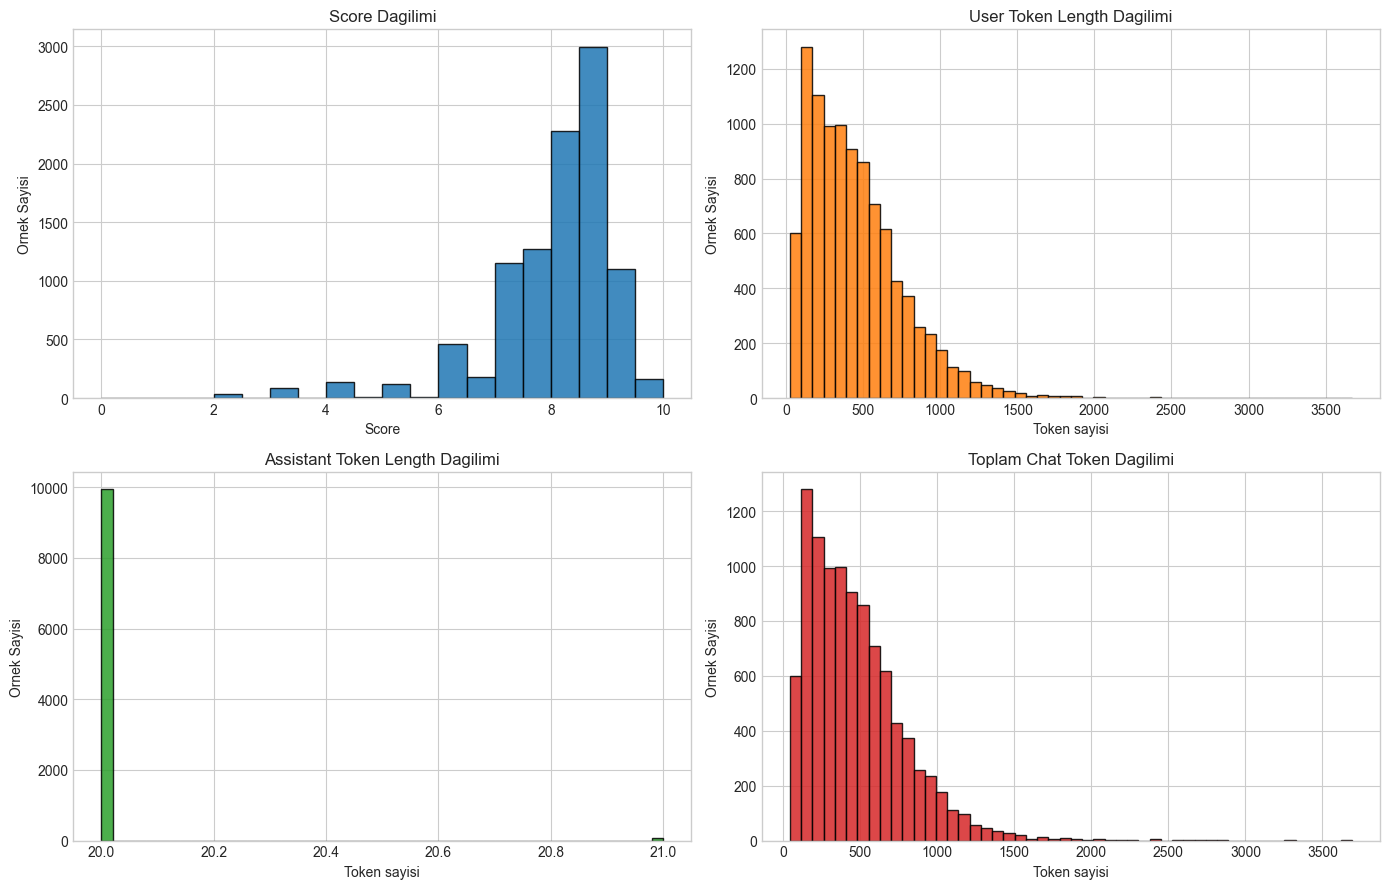

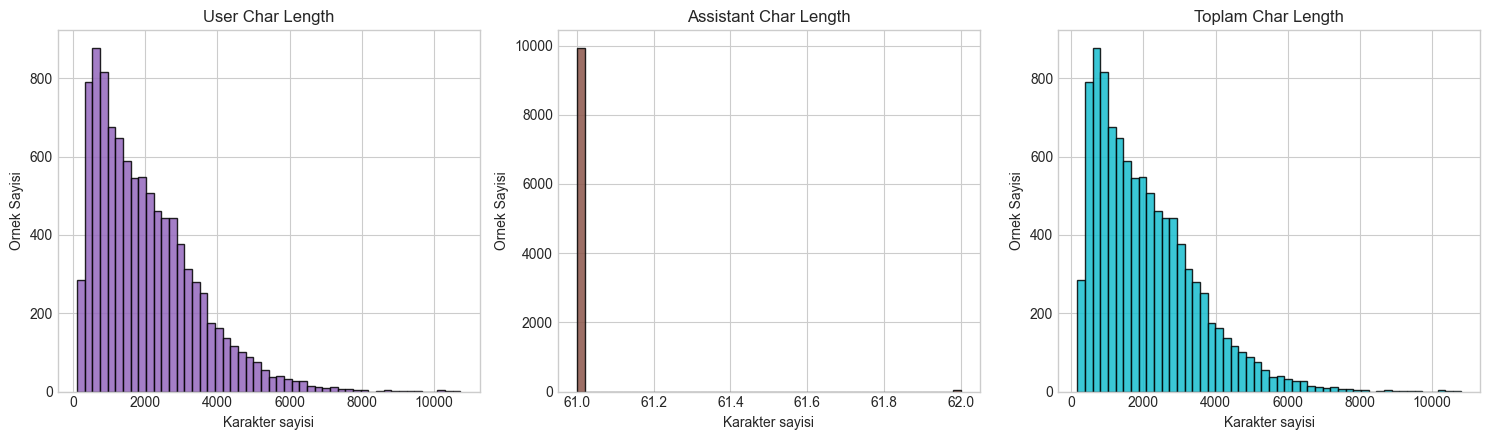

Grafikler kaydedildi: /Users/enesdemir/Documents/genrm_finetune/artifacts/eda


In [5]:
# Histogramlar
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

axes[0, 0].hist(df["score"].dropna(), bins=np.arange(0, 10.5, 0.5), color="#1f77b4", edgecolor="black", alpha=0.85)
axes[0, 0].set_title("Score Dagilimi")
axes[0, 0].set_xlabel("Score")
axes[0, 0].set_ylabel("Ornek Sayisi")

axes[0, 1].hist(df["user_tokens"], bins=50, color="#ff7f0e", edgecolor="black", alpha=0.85)
axes[0, 1].set_title("User Token Length Dagilimi")
axes[0, 1].set_xlabel("Token sayisi")
axes[0, 1].set_ylabel("Ornek Sayisi")

axes[1, 0].hist(df["assistant_tokens"], bins=50, color="#2ca02c", edgecolor="black", alpha=0.85)
axes[1, 0].set_title("Assistant Token Length Dagilimi")
axes[1, 0].set_xlabel("Token sayisi")
axes[1, 0].set_ylabel("Ornek Sayisi")

axes[1, 1].hist(df["chat_tokens"], bins=50, color="#d62728", edgecolor="black", alpha=0.85)
axes[1, 1].set_title("Toplam Chat Token Dagilimi")
axes[1, 1].set_xlabel("Token sayisi")
axes[1, 1].set_ylabel("Ornek Sayisi")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "token_and_score_histograms.png", dpi=160, bbox_inches="tight")
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
axes[0].hist(df["user_chars"], bins=50, color="#9467bd", edgecolor="black", alpha=0.85)
axes[0].set_title("User Char Length")
axes[0].set_xlabel("Karakter sayisi")
axes[0].set_ylabel("Ornek Sayisi")

axes[1].hist(df["assistant_chars"], bins=50, color="#8c564b", edgecolor="black", alpha=0.85)
axes[1].set_title("Assistant Char Length")
axes[1].set_xlabel("Karakter sayisi")
axes[1].set_ylabel("Ornek Sayisi")

axes[2].hist(df["total_chars"], bins=50, color="#17becf", edgecolor="black", alpha=0.85)
axes[2].set_title("Toplam Char Length")
axes[2].set_xlabel("Karakter sayisi")
axes[2].set_ylabel("Ornek Sayisi")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "char_histograms.png", dpi=160, bbox_inches="tight")
plt.show()

print(f"Grafikler kaydedildi: {OUTPUT_DIR.resolve()}")

In [6]:
# En uzun sequence ornekleri (debug/inspect icin)
display(df.nlargest(10, "chat_tokens")[["idx", "score", "user_tokens", "assistant_tokens", "chat_tokens"]])

,idx,score,user_tokens,assistant_tokens,chat_tokens
4535,4535,5.0,3671,20,3691
2136,2136,8.5,3249,20,3269
7942,7942,7.5,2831,20,2851
160,160,1.0,2796,20,2816
1358,1358,6.0,2767,20,2787
5334,5334,8.0,2677,20,2697
7048,7048,8.5,2648,20,2668
6987,6987,8.0,2569,20,2589
9648,9648,8.0,2557,20,2577
2149,2149,7.0,2393,20,2413
